In [22]:
!pip install kneed

In [23]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Basic configuration
DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [24]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

##### Loade Price Data

In [25]:
price_matrix, symbols = load_and_prepare_data('./sim_daily.parquet')

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 100
Total trading days: 1022



$$ \text{Rendite} = \frac{1}{T} \sum_{t=1}^{T} \frac{P_t - P_{t-1}}{P_{t-1}} \times \text{Trading days per year} $$


$$ \text{Volatilität} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} \left( \frac{P_t - P_{t-1}}{P_{t-1}} - \mu \right)^2} \times \sqrt{\text{Trading days per year}} $$


In [26]:
def calculate_metrics(price_matrix):
    returns = price_matrix.pct_change().mean() * DATE_CONFIG['TRADING_DAYS_PER_YEAR']
    metrics = pd.DataFrame(returns, columns=['returns'])
    metrics['volatility'] = price_matrix.pct_change().std() * np.sqrt(DATE_CONFIG['TRADING_DAYS_PER_YEAR'])
    return metrics

##### Validate metrics

In [27]:
metrics = calculate_metrics(price_matrix)
print("Erste 5 Zeilen der Metriken:")
print(metrics.head())
print("\nBeschreibung der Metriken:")
print(metrics.describe())

Erste 5 Zeilen der Metriken:
         returns  volatility
symbol                      
ADDRO  -0.176452    0.580123
AFIWZ   0.126950    0.609487
AFQOF   0.203174    0.602236
AQDMB   0.265521    0.593119
ATIYU  -0.048528    0.603129

Beschreibung der Metriken:
          returns  volatility
count  100.000000  100.000000
mean    -0.113399    0.600860
std      0.320108    0.012266
min     -0.780331    0.574585
25%     -0.302854    0.593450
50%     -0.085726    0.599862
75%      0.102980    0.609759
max      0.640650    0.627343


##### Scale Transform
The StandardScaler transforms our features (returns and volatility) to have zero mean and unit variance, which eliminates the scale difference between our variables and prevents higher magnitude features from dominating. This standardization is crucial for many machine learning algorithms as it ensures that all features contribute equally to the model and helps prevent numerical instabilities during the optimization process.

In [28]:
def scale_metrics(metrics):
    scaler = StandardScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(metrics),
        columns=metrics.columns,
        index=metrics.index
    )
    return scaled

In [29]:
X = scale_metrics(metrics)
print("Erste 5 Zeilen der skalierten Daten:")
print(X.head())
print("\nBeschreibung der skalierten Daten:")
print(X.describe())

Erste 5 Zeilen der skalierten Daten:
         returns  volatility
symbol                      
ADDRO  -0.197966   -1.699223
AFIWZ   0.754620    0.706827
AFQOF   0.993938    0.112715
AQDMB   1.189690   -0.634296
ATIYU   0.203676    0.185847

Beschreibung der skalierten Daten:
            returns    volatility
count  1.000000e+02  1.000000e+02
mean   1.915135e-17  1.461054e-15
std    1.005038e+00  1.005038e+00
min   -2.093955e+00 -2.152964e+00
25%   -5.948273e-01 -6.072121e-01
50%    8.688601e-02 -8.180786e-02
75%    6.793608e-01  7.291535e-01
max    2.367477e+00  2.169941e+00


# Affinity Propagation Clustering

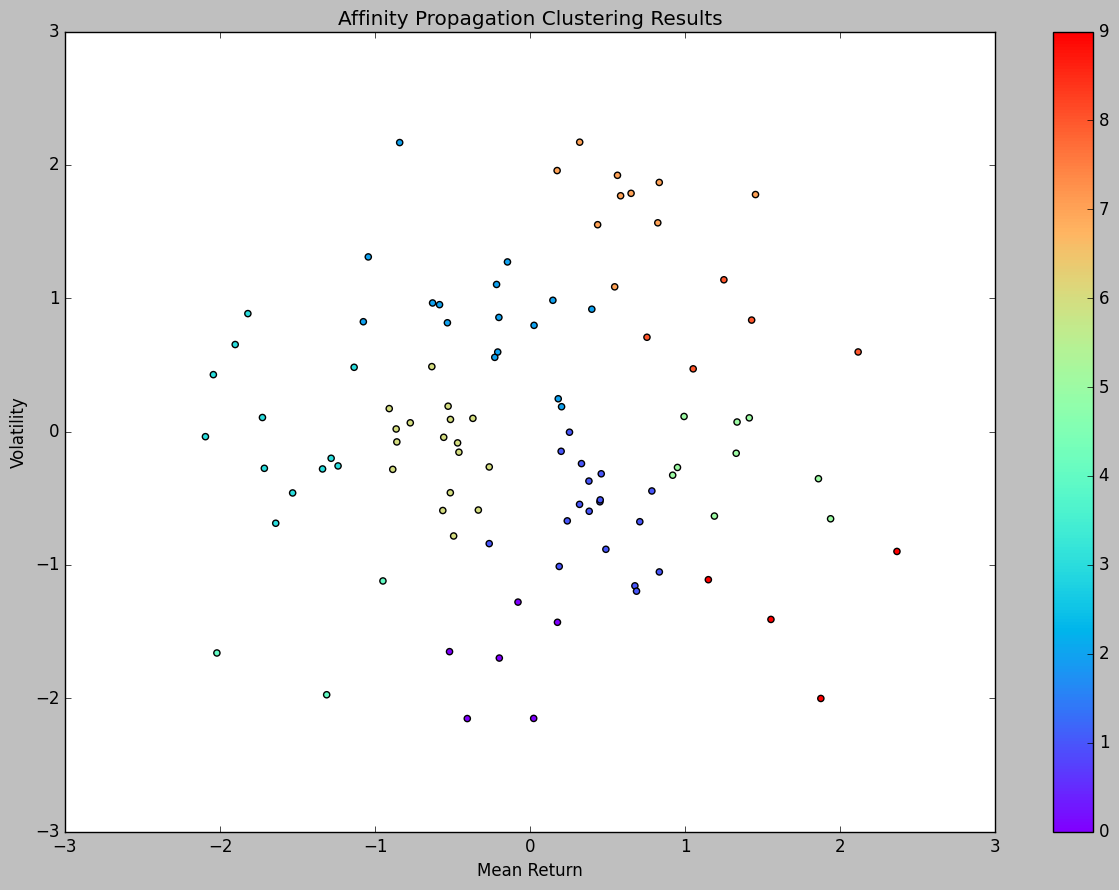

In [30]:
ap = AffinityPropagation()
ap.fit(X)
labels1 = ap.predict(X)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels1, cmap='rainbow')
ax.set_title('Affinity Propagation Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

The number of clusters is: 10


<Figure size 1200x600 with 0 Axes>

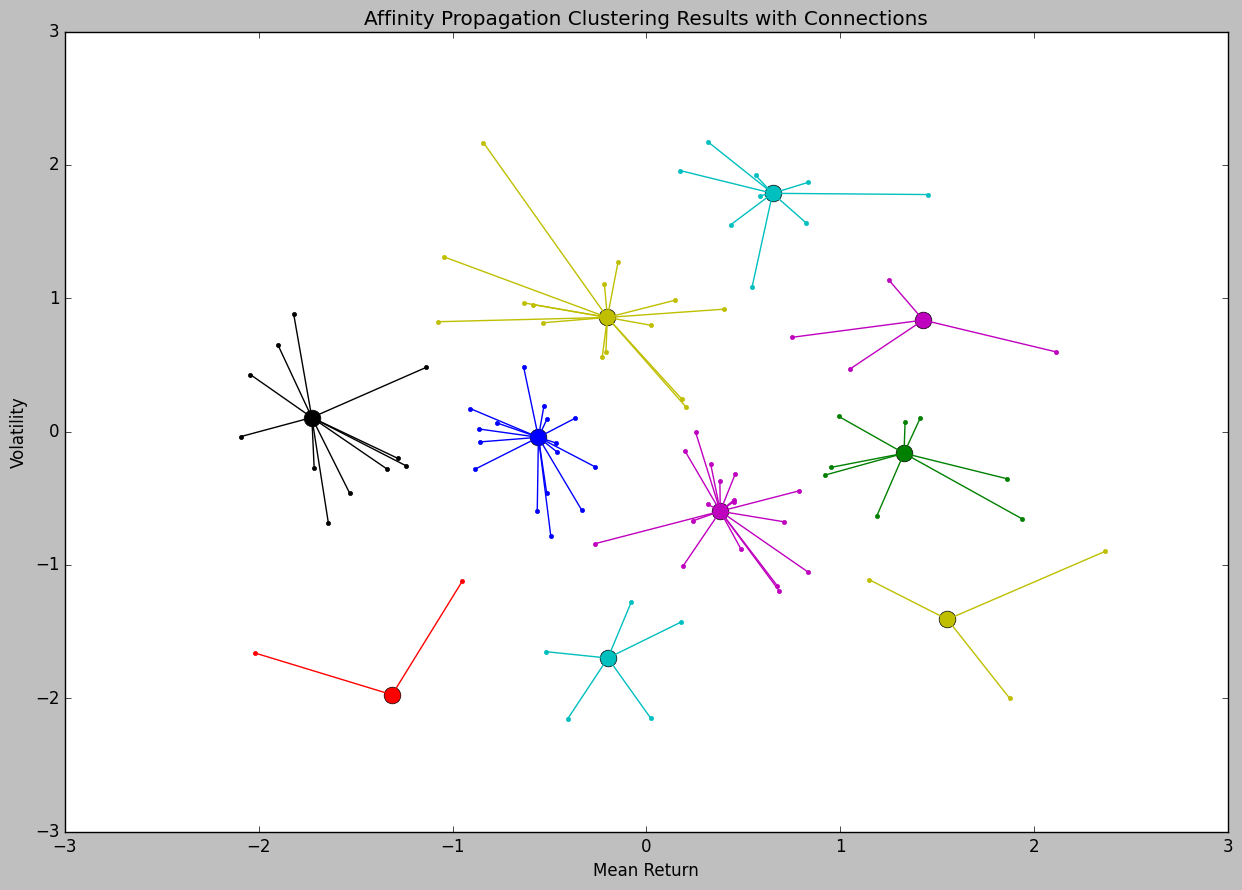

In [31]:
from itertools import cycle

#Extract the cluster centers and labels
cci = ap.cluster_centers_indices_
labels2 = ap.labels_

#Print their number
clusters = len(cci)
print('The number of clusters is:',clusters)

#Plot the results
X_ap = np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf
fig=plt.figure(figsize=(15,10))
colors = cycle('cmykrgbcmykrgbcmykrgbcmykrgb')
for k, col in zip(range(clusters),colors):
    cluster_members = labels2 == k
    cluster_center = X_ap[cci[k]]
    plt.plot(X_ap[cluster_members, 0], X_ap[cluster_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=12)
    for x in X_ap[cluster_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propagation Clustering Results with Connections')
plt.xlabel('Mean Return')
plt.ylabel('Volatility')
plt.show()

In [32]:
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

cluster_size_limit = 1000
counts = clustered_series_ap.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print("Number of clusters:", len(ticker_count))
print("Number of Pairs:", (ticker_count*(ticker_count-1)).sum())

Number of clusters: 10
Number of Pairs: 1180


In [33]:
def find_cointegrated_pairs(price_matrix, pvalue_threshold=0.01):
    n = price_matrix.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    symbols = price_matrix.columns
    pairs = []
    results = []
    
    total_pairs = sum(range(n))
    with tqdm(total=total_pairs, desc="Analyzing pairs") as pbar:
        for i in range(n):
            for j in range(i+1, n):
                S1 = price_matrix[symbols[i]]
                S2 = price_matrix[symbols[j]]
                
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                
                results.append({
                    'symbol1': symbols[i],
                    'symbol2': symbols[j],
                    'p_value': pvalue,
                    'score': score
                })
                
                if pvalue <= pvalue_threshold:
                    pairs.append((symbols[i], symbols[j]))
                    
                pbar.update(1)
    
    return score_matrix, pvalue_matrix, pairs, results

def analyze_pairs(price_matrix, pvalue_threshold=0.01):
    score_matrix, pvalue_matrix, pairs, results = find_cointegrated_pairs(
        price_matrix, 
        pvalue_threshold
    )
    
    print(f"\nAnalysis complete!")
    print(f"Found {len(pairs)} cointegrated pairs")
    print(f"Total pairs analyzed: {len(results)}")
    
    summary_df = pd.DataFrame(results)
    summary_df['is_cointegrated'] = summary_df['p_value'] <= pvalue_threshold
    
    return score_matrix, pvalue_matrix, pairs, summary_df

def plot_cointegration_heatmap(pvalue_matrix, symbols, max_pvalue=0.98):
    plt.figure(figsize=(12, 8))
    mask = (pvalue_matrix >= max_pvalue)
    
    sns.heatmap(
        pvalue_matrix, 
        xticklabels=symbols, 
        yticklabels=symbols, 
        cmap='RdYlGn_r',
        mask=mask
    )
    
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('Cointegration p-values heatmap')
    plt.tight_layout()
    plt.show()

Analyzing pairs: 100%|██████████| 15/15 [00:00<00:00, 56.33it/s]



Analysis complete!
Found 1 cointegrated pairs
Total pairs analyzed: 15

Cluster 0 pairs:
MFKBJ - XCKAF


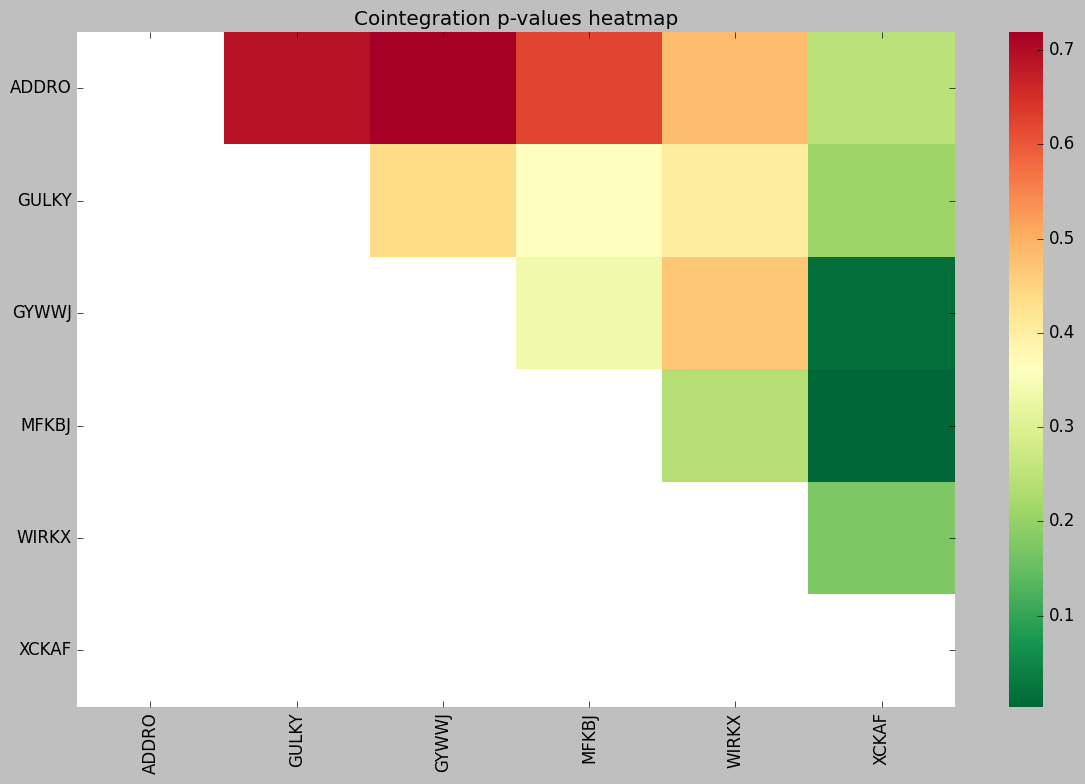

Analyzing pairs: 100%|██████████| 153/153 [00:02<00:00, 71.88it/s]



Analysis complete!
Found 14 cointegrated pairs
Total pairs analyzed: 153

Cluster 1 pairs:
COHPS - FAIGF
COHPS - IPFFB
COHPS - LYWGN
COHPS - NMLTG
COHPS - OSEHZ
COHPS - QAHFT
COHPS - QKZNY
COHPS - TOLAB
COHPS - TOUNA
COHPS - VSPZR
COHPS - WYCMB
COHPS - YKSBR
COHPS - ZQLND
COHPS - ZQORV


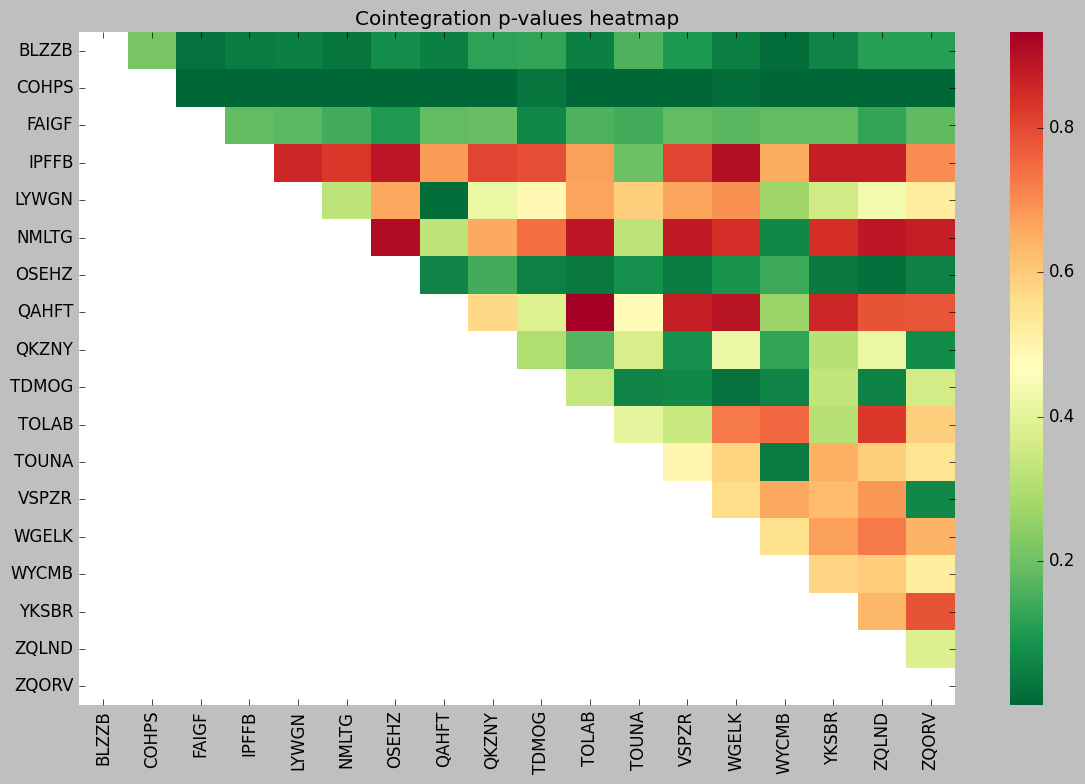

Analyzing pairs: 100%|██████████| 120/120 [00:01<00:00, 70.53it/s]



Analysis complete!
Found 15 cointegrated pairs
Total pairs analyzed: 120

Cluster 2 pairs:
FITJT - GCUWK
FITJT - GDXGP
GCAOZ - GDXGP
GCAOZ - GGOGP
GCAOZ - LFOSF
GCAOZ - TNQHC
GCAOZ - ZVZYW
GGOGP - LFOSF
JAJTW - LFOSF
JAJTW - SRZCK
JAJTW - TNQHC
JAJTW - VCWGM
JAJTW - XQHOA
JAJTW - ZVZYW
TNQHC - VCWGM


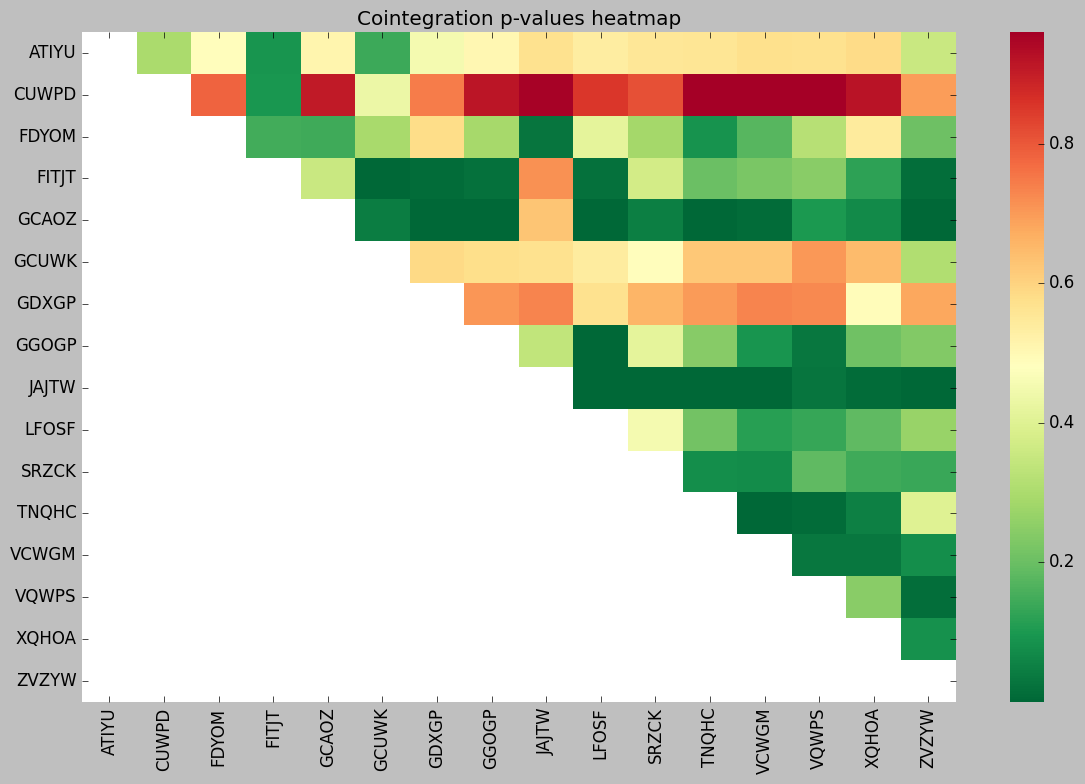

Analyzing pairs: 100%|██████████| 66/66 [00:01<00:00, 65.10it/s]



Analysis complete!
Found 7 cointegrated pairs
Total pairs analyzed: 66

Cluster 3 pairs:
AYWVH - FAGMW
EYWZV - FXWBG
EYWZV - GSAYN
EYWZV - VHRYD
FAGMW - KPNYF
FXWBG - RATUC
FXWBG - XPSNV


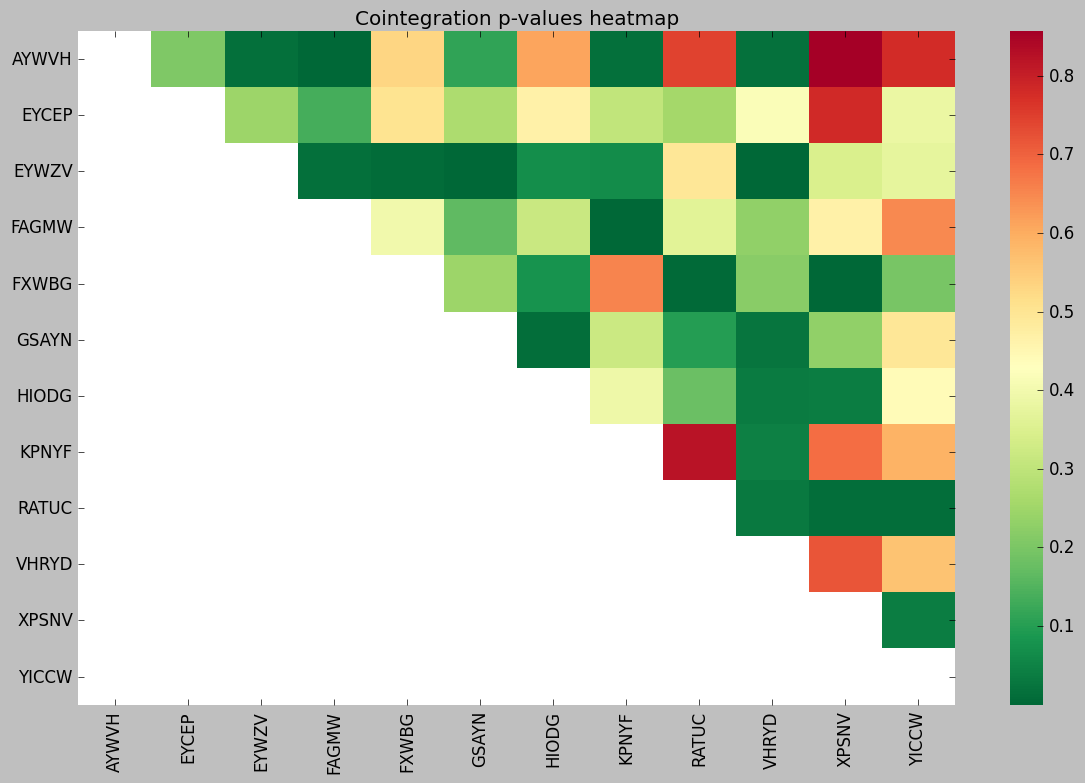

Analyzing pairs: 100%|██████████| 3/3 [00:00<00:00, 63.12it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 3


Analyzing pairs: 100%|██████████| 36/36 [00:00<00:00, 64.49it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 36


Analyzing pairs: 100%|██████████| 136/136 [00:02<00:00, 66.33it/s]



Analysis complete!
Found 6 cointegrated pairs
Total pairs analyzed: 136

Cluster 6 pairs:
IXUWX - QPESE
MDQAK - SBKOK
QPESE - RNGQC
QPESE - VGUCW
QPESE - XWHQP
VGUCW - XWHQP


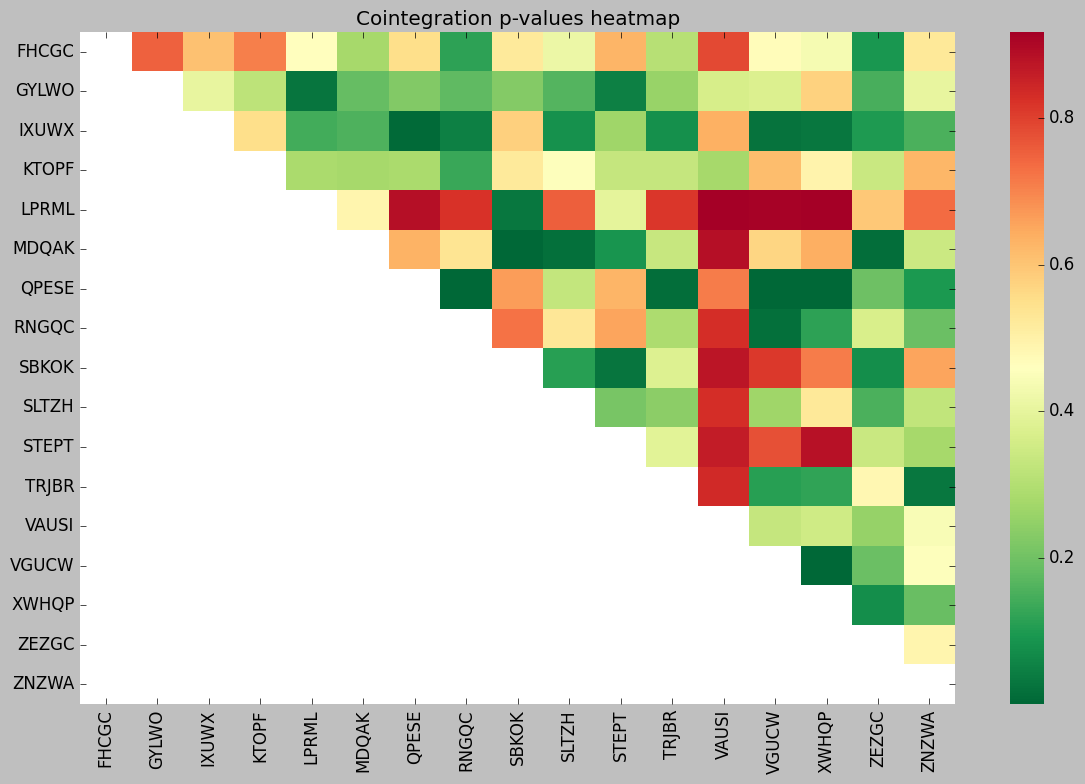

Analyzing pairs: 100%|██████████| 45/45 [00:00<00:00, 65.34it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 45


Analyzing pairs: 100%|██████████| 10/10 [00:00<00:00, 60.85it/s]



Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 10


Analyzing pairs: 100%|██████████| 6/6 [00:00<00:00, 66.01it/s]


Analysis complete!
Found 0 cointegrated pairs
Total pairs analyzed: 6


In [34]:
all_pairs_with_clusters = []

for cluster_id in np.unique(ap.labels_):
    cluster_mask = ap.labels_ == cluster_id
    cluster_symbols = X.index[cluster_mask]
    
    if len(cluster_symbols) > 1:
        cluster_prices = price_matrix[cluster_symbols]
        score_matrix, pvalue_matrix, pairs, _ = analyze_pairs(
            cluster_prices,
            pvalue_threshold=0.01
        )
        
        if len(pairs) > 0:
            for pair in pairs:
                all_pairs_with_clusters.append({
                    'pair': pair,
                    'cluster': cluster_id
                })
            print(f"\nCluster {cluster_id} pairs:")
            for pair in pairs:
                print(f"{pair[0]} - {pair[1]}")
                
            plot_cointegration_heatmap(pvalue_matrix, cluster_symbols)

all_pairs = [item['pair'] for item in all_pairs_with_clusters]

In [35]:
stocks = np.unique(all_pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = pd.Series(index=stocks, data=[ap.labels_[list(X.index).index(stock)] for stock in stocks])
stocks = list(np.unique(all_pairs))
X_pairs = X_data.T.loc[stocks]

In [36]:

X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)

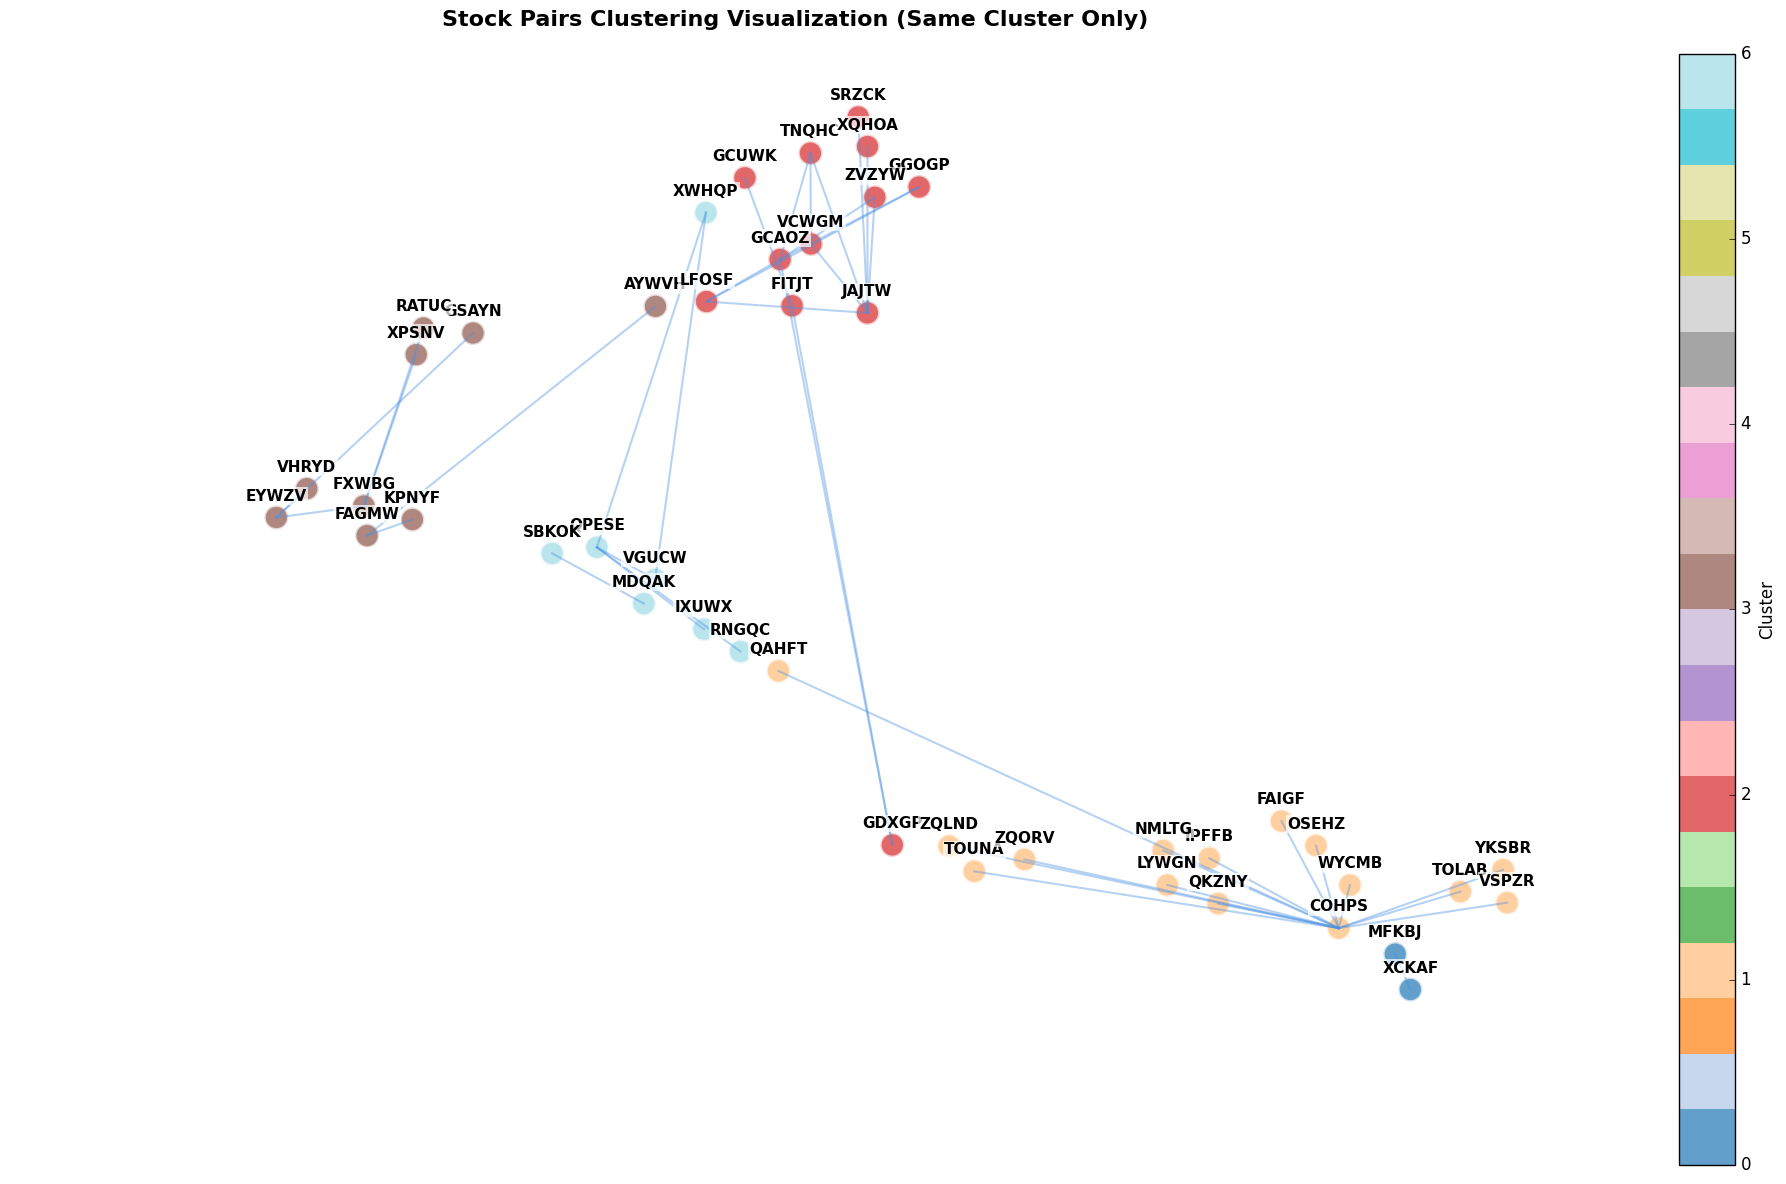

In [37]:

plt.figure(figsize=(20,12), facecolor='white')
plt.clf()
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

for item in all_pairs_with_clusters:
    pair = item['pair']
    cluster = item['cluster']
    loc1 = X_pairs.index.get_loc(pair[0])
    loc2 = X_pairs.index.get_loc(pair[1])
    x1, y1 = X_tsne[loc1, :]
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], '-', alpha=0.4, linewidth=1.5, color='#4a90e2')

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     s=300,
                     alpha=0.7,
                     c=in_pairs_series.values,
                     cmap='tab20',
                     edgecolor='white',
                     linewidth=2)

for x, y, name in zip(X_tsne[:,0], X_tsne[:,1], X_pairs.index):
    plt.annotate(name,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                va='bottom',
                fontsize=11,
                fontweight='bold',
                bbox=dict(facecolor='white', 
                         edgecolor='none',
                         alpha=0.7,
                         pad=1))

plt.title('Stock Pairs Clustering Visualization (Same Cluster Only)', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.axis('off')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [38]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window=50, std_dev=1.5):
    model = sm.OLS(S1_train, S2_train)
    hedge_ratio = model.fit().params[0]
    
    spread_test = S1_test - (S2_test * hedge_ratio)
    
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    prev_spread = None
    
    for i in range(len(spread_test)):
        current_date = spread_test.index[i]
        current_spread = spread_test.iloc[i]
        
        rolling_mean = spread_test.iloc[:i+1].rolling(window=window, center=False).mean().iloc[-1]
        rolling_std = spread_test.iloc[:i+1].rolling(window=window, center=False).std().iloc[-1]
        
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        if prev_spread is not None:
            if position == 0:
                if prev_spread > lower_band and current_spread < lower_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "long"},
                        symbol2: {"price": S2_test.iloc[i], "type": "short"}
                    }
                    position = 1
                    
                elif prev_spread < upper_band and current_spread > upper_band:
                    entry_date = current_date
                    entry_prices = {
                        symbol1: {"price": S1_test.iloc[i], "type": "short"},
                        symbol2: {"price": S2_test.iloc[i], "type": "long"}
                    }
                    position = -1
                    
            elif ((position == 1 and prev_spread < upper_band and current_spread > upper_band) or 
                  (position == -1 and prev_spread > lower_band and current_spread < lower_band)):
                
                for symbol in [symbol1, symbol2]:
                    trades.append({
                        'trade_id': trade_id,
                        'symbol': symbol,
                        'entry_date': entry_date,
                        'entry_price': entry_prices[symbol]["price"],
                        'exit_date': current_date,
                        'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                        'position_type': entry_prices[symbol]["type"],
                        'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                        'exit_type': 'target'
                    })
                position = 0
                trade_id += 1
                
        prev_spread = current_spread
            
    return trades

def backtest_pairs(price_matrix, pairs, train_end_date):
    all_trades = []
    
    for symbol1, symbol2 in pairs:
        training_mask = price_matrix.index < train_end_date
        
        S1_train = price_matrix[symbol1][training_mask]
        S2_train = price_matrix[symbol2][training_mask]
        S1_test = price_matrix[symbol1][~training_mask]
        S2_test = price_matrix[symbol2][~training_mask]
        
        pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
        all_trades.extend(pair_trades)
    
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('./results/apcluster_bollinger_results.parquet')
    
    return trades_df

In [39]:
trades_df = backtest_pairs(price_matrix, all_pairs, DATE_CONFIG['TRAIN_END'])